# **Reinforcement Learning**

<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:
```
!pip uninstall gym -y
!pip install gym
```

<br>
<br>
<br>
<br>

<center><img src="https://media.tenor.com/zOoVaNGp6IsAAAAd/mario-game.gif"><center>

In [ ]:
# !pip install -U gym==0.25.2
!pip install autorom[accept-rom-license]
!pip install swig
!pip install gym[all]

In [2]:
import random
import math
import copy
from tqdm.auto import tqdm
from collections import defaultdict, deque, namedtuple
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import adamw
from torch.distributions import Normal


from torch.autograd import Variable

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import warnings
warnings.filterwarnings('ignore')

In [3]:
def display_video(episode=0, video_width=600, video_dir= "/content/video"):
    video_path = os.path.join(video_dir, f"rl-video-episode-{episode}.mp4")
    video_file = open(video_path, "rb").read()
    decoded = b64encode(video_file).decode()
    video_url = f"data:video/mp4;base64,{decoded}"
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode=None, video_folder='/content/video'):
    # render mode: "human", "rgb_array", "ansi")
    env = gym.make(name, new_step_api=True, render_mode=render_mode)
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 50 == 0)
    env = RecordEpisodeStatistics(env)
    return env

## **Proximal Policy Optimization(PPO)**

- ### *vanilla policy gradient* (VPG):

We have been using this method until now, which is a stochastic policy. It explore the environment without using $\epsilon-greedy$.

$$
\large \theta = \theta + \alpha \nabla_\theta J(\theta)|_{\theta = \theta_{old}}
$$

<br>

The gradient evaluate old policy based on $\theta$ parameter and update it based on learning rate ($\alpha$). Nonetheless, A tiny change in $\theta$ could cause a significant change in the policy probabilities. In fact, we would like to keep the old and new policies close to each other in $\pi_\theta(s_t, a_t)$ and not in $\theta$.

<br>

- ### *Kullback-Liebler divergence* (KL-divergence):

it is a measure of how one probability distribution $Q$ (*the approximate distribution*) differs from a second, reference probability distribution $P$ (*the true distribution*).

Discrete probability distributions:

$$
D_{\text{KL}}(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \frac{P(x)}{Q(x)}
$$

<br>

Continuous distributions:

$$
\begin{split}
D_{\text{KL}}(P \| Q) & = \int_{-\infty}^{\infty} P(x) \log \frac{P(x)}{Q(x)} \, dx \\
\\
\text{Gaussian distributions: }\\
\\
\text{KL}(P || Q) & = \log\left(\frac{\sigma_{\text{old}}}{\sigma}\right) + \frac{\sigma^2 + (\mu - \mu_{\text{old}})^2}{2\sigma_{\text{old}}^2} - 0.5
\end{split}
$$

> $P(x)$ : The true probability distribution (e.g., target distribution). <br>$Q(x)$ : The approximate probability distribution. <br>$\mathcal{X}$ : The support (range of possible values) of the distributions. <br>$\log$ : Typically the natural logarithm.

---
- For Gaussian distributions $P = \mathcal{N}(\mu, \sigma^2)$ and $Q = \mathcal{N}(\mu_{\text{old}}, \sigma_{\text{old}}^2)$, their probability density functions are:

$P(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right) \\
Q(x) = \frac{1}{\sqrt{2\pi\sigma_{\text{old}}^2}} \exp\left(-\frac{(x - \mu_{\text{old}})^2}{2\sigma_{\text{old}}^2}\right) \\
\log P(x) = -\frac{1}{2} \log (2\pi) - \frac{1}{2} \log \sigma^2 - \frac{(x - \mu)^2}{2\sigma^2} \\
\log Q(x) = -\frac{1}{2} \log (2\pi) - \frac{1}{2} \log \sigma_{\text{old}}^2 - \frac{(x - \mu_{\text{old}})^2}{2\sigma_{\text{old}}^2}$

<br>

$$
\begin{split}
\text{KL}(P || Q) & = \int P(x) \left[ \log P(x) - \log Q(x) \right] dx \\
\text{KL}(P || Q) & = \int P(x) \left[ -\frac{1}{2} \log \sigma^2 - \frac{(x - \mu)^2}{2\sigma^2} + \frac{1}{2} \log \sigma_{\text{old}}^2 + \frac{(x - \mu_{\text{old}})^2}{2\sigma_{\text{old}}^2} \right] dx \\
\text{KL}(P || Q) & = \int P(x) \left[  \log \frac{\sigma_{old}}{\sigma^2} - \frac{(x - \mu)^2}{2\sigma^2} + \frac{(x - \mu_{\text{old}})^2}{2\sigma_{\text{old}}^2} \right] dx \\
\text{KL}(P || Q) & = \int P(x)  \log \frac{\sigma_{old}}{\sigma^2} - \int P(x) \frac{(x - \mu)^2}{2\sigma^2} + \int P(x) \frac{(x - \mu_{\text{old}})^2}{2\sigma_{\text{old}}^2} dx \\
\text{KL}(P || Q) & = \log \frac{\sigma_{old}}{\sigma^2} \int P(x) - \frac{1}{2\sigma^2} \int P(x) (x - \mu)^2 + \frac{1}{2\sigma_{\text{old}}^2} \int P(x) (x - \mu_{\text{old}})^2 dx \\
\text{KL}(P || Q) & = \log \frac{\sigma_{old}}{\sigma^2} - \frac{\sigma^2}{2\sigma^2} + \frac{\sigma^2 + 0 + (\mu - \mu_{\text{old}})^2}{2\sigma_{\text{old}}^2} \\
\text{KL}(P || Q) & = \log \frac{\sigma_{old}}{\sigma^2} - \frac{1}{2} + \frac{\sigma^2 + (\mu - \mu_{\text{old}})^2}{2\sigma_{\text{old}}^2} \\
\end{split}
$$

<br>

> $\int_{-\infty}^{\infty} P(x) = 1 \\
\int_{-\infty}^\infty P(x)(x - \mu)^2 \, dx = \text{Variance} = \sigma^2 \\
\int P(x)(x - \mu) = \text{Mean} = 0 \\
\scriptsize (x - \mu_{\text{old}})^2 = ((x - \mu) + (\mu - \mu_{\text{old}}))^2 = (x - \mu)^2 + 2(x - \mu)(\mu - \mu_{\text{old}}) + (\mu - \mu_{\text{old}})^2 \\
\int_{-\infty}^\infty P(x) (x - \mu_{\text{old}})^2 dx = \int P(x)(x - \mu)^2 + \int P(x)2(x - \mu)(\mu - \mu_{\text{old}}) + \int P(x)(\mu - \mu_{\text{old}})^2 \\
\int P(x) (x - \mu_{\text{old}})^2 dx = \sigma^2 + 0 + (\mu - \mu_{\text{old}})^2\int P(x) \\ $

---

<br>

1. **Asymmetry**: KL-divergence is not symmetric, $D_{\text{KL}}(P \| Q) \neq D_{\text{KL}}(Q \| P)$. This makes it a “divergence” rather than a true “distance.”
2. **Non-negativity**:$ D_{\text{KL}}(P \| Q) \geq 0$, with equality if and only if $P = Q$ almost everywhere.
3. **Measures information loss**: It quantifies the information lost when $Q$ is used to approximate $P$.

<br>

---
- ### **Example for discrete distribution**

$$
P(x) = \left[ \frac{1}{3}, \frac{1}{3}, \frac{1}{3} \right]\\
Q(x) = \left[ \frac{1}{3}, \frac{1}{6}, \frac{1}{2} \right]
$$

The formula for KL-divergence is:

$$
D_{\text{KL}}(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \frac{P(x)}{Q(x)}
$$

<br>

|$Outcome (x_i)$ | $P(x_i)$ | $Q(x_i)$ | $\frac{P(x_i)}{Q(x_i)}$ | $\log \frac{P(x_i)}{Q(x_i)}$ | $P(x_i) \log \frac{P(x_i)}{Q(x_i)}$|
|------------|------------|----|------------|------------|------------|
| $x_1$ | $\frac{1}{3}$ | $\frac{1}{3}$ | $\frac{\frac{1}{3}}{\frac{1}{3}} = 1$ | $\log 1 = 0$ | $\frac{1}{3} \cdot 0 = 0$|
| $x_2$ | $\frac{1}{3}$ | $\frac{1}{6}$ | $\frac{\frac{1}{3}}{\frac{1}{6}} = 2$ | $\log 2 = 0.693$ | $\frac{1}{3} \cdot 0.693 = 0.231$|
| $x_3$ | $\frac{1}{3}$ | $\frac{1}{2}$ | $\frac{\frac{1}{3}}{\frac{1}{2}} = \frac{2}{3}$ | $\log \frac{2}{3} = -0.405$ | $\frac{1}{3} \cdot -0.405 = -0.135$|

<br>

$$
D_{\text{KL}}(P \| Q) = 0 + 0.231 - 0.135 = 0.096
$$

---

<br>

As we mentioned that KL divergence is not symmetric $D_{\text{KL}}(P \| Q) \neq D_{\text{KL}}(Q \| P)$ .KL divergence is a kind of pseudomeasure of distance between two probability distributions.

We want to keep the new and old policies probability space close to each other.

$$
\large D_{KL}(\pi_\theta^{\text{updated}}(a|s)||\pi_\theta^{\text{current}}(a|s)\leq \delta
$$

<br>

> $\pi_\theta^{\text{updated}}(a|s)$ is the updated policy. we will use $\pi_\theta(a|s)$  <br>
$\pi_\theta^{\text{current}}(a|s)$ is the old/current policy. we will use  $\pi_\theta^{\text{old}}(a|s)$ <br>
$\delta$  is the maximum allowable KL-divergence.

<br>

- To incorporate this into the optimization, we move toward a substitute objective that uses the advantage function $A^{\pi_{\theta_{\text{old}}}}(s, a)$.

$$
\large D_{\text{KL}}(\pi_\theta \| \pi_\theta^{\text{old}}) = \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \log \frac{\pi_\theta(a|s)}{\pi_\theta^{\text{old}}(a|s)} \right]
$$

<br>

- we can use a Lagrangian formulation:

$$
\large J(\pi_\theta \| \pi_\theta^{\text{old}}) = \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A^{\pi_{\theta_{\text{old}}}}(s, a) \right]
$$

<br>

> $\frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}$ is the ratio of new to old policy probabilities. <br>
$A^{\pi_{\theta_{\text{old}}}}(s, a)$ is the advantage function.

<br>

### **How we get there**

---
---
- Lagrangian formulation:

1. Objective Function: We aim to maximize the expected return based on the advantage function$ A^{\pi_{\theta_{\text{old}}}}(s, a)$. The objective without constraints is:

$$
\mathbb{E}_{a \sim \pi_\theta} \left[ A^{\pi_{\theta_{\text{old}}}}(s, a) \right].
$$

2. Constraint: To ensure the new policy  \pi_\theta  does not deviate too far from the old policy $\pi_{\theta_{\text{old}}}$, we impose the KL-divergence constraint:

$$
D_{\text{KL}}(\pi_\theta \| \pi_{\theta_{\text{old}}}) \leq \delta.
$$

- combine the objective and constraint into a Lagrangian

$$
\mathcal{L}(\theta, \lambda) = \mathbb{E}_{a \sim \pi_\theta} \left[ A^{\pi_{\theta_{\text{old}}}}(s, a) \right] - \lambda \left( D_{\text{KL}}(\pi_\theta \| \pi_{\theta_{\text{old}}}) - \delta \right)
\
$$

>  $\lambda \geq 0$ is the Lagrange multiplier enforcing the KL-divergence constraint. <br>
$\lambda D_{\text{KL}}(\pi_\theta \| \pi_{\theta_{\text{old}}})$ penalizes the objective if the KL-divergence exceeds  $\delta$.

<br>

$$
D_{\text{KL}}(\pi_\theta \| \pi_{\theta_{\text{old}}}) = \mathbb{E}_{a \sim \pi_\theta} \left[ \log \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} \right]
$$

To align the expectation with $\pi_{\theta_{\text{old}}}$ instead of  $\pi_\theta$, we rewrite the expectations using importance sampling:

$$
\mathbb{E}_{a \sim \pi_\theta} \left[ f(a) \right] = \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} f(a) \right]
$$

So, now we have this:

$$
\mathcal{L}(\theta, \lambda) = \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A^{\pi_{\theta_{\text{old}}}}(s, a) \right] - \lambda \left( \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} \log \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} \right] - \delta \right)
$$

- Simplifying:
     1. The term $-\lambda \delta$ is constant for optimization over  \theta , so it can be ignored during gradient updates.
     2. For simplicity, if we approximate the KL-divergence constraint$ D_{\text{KL}}(\pi_\theta \| \pi_{\theta_{\text{old}}}) \leq \delta$ with a penalty-free optimization (no explicit $\lambda$), we focus only on the first term:

1.
$$
\mathcal{L}(\theta, \lambda) = \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} \left( A^{\pi_{\theta_{\text{old}}}}(s, a) - \lambda \log \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} \right) \right].
$$

2.
$$
\mathcal{L}(\theta) = \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A^{\pi_{\theta_{\text{old}}}}(s, a) \right].
$$

---
---

<br>

$$
\large \pi_{\text{old}+1}= \underset{\pi}{\text{argmax}}J(\pi_\theta \| \pi_\theta^{\text{old}})
$$

### **Add the new term to derivarive**


$$
D_{\text{KL}}(\pi_\theta \| \pi_\theta^{\text{old}}) = \mathbb{E}{a \sim \pi_{\theta_{\text{old}}}} \left[ \log \frac{\pi_\theta(a|s)}{\pi_\theta^{\text{old}}(a|s)} \right]
$$

$$
J(\pi_\theta \| \pi_\theta^{\text{old}}) = \mathbb{E}{a \sim \pi_{\theta_{\text{old}}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A^{\pi_{\theta_{\text{old}}}}(s, a) \right]
$$

> $\frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}$ is the ratio of new to old policy probabilities. <br>
$A^{\pi_{\theta_{\text{old}}}}(s, a)$ is the advantage function.

<br>

To handle the KL-divergence constraint, we penalize deviations beyond the limit $\delta$:

$$
\large L(\theta) - \beta D_{\text{KL}}(\pi_\theta \| \pi_{\theta_{\text{old}}}),
$$

> $\beta > 0$  is a penalty coefficient.

<br>

Taylor Expansion of KL-Divergence

The KL-divergence can be approximated using a first-order Taylor expansion:
$$
D_{\text{KL}}(\pi_\theta \| \pi_{\theta_{\text{old}}}) \approx \frac{1}{2} \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \left( \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} - 1 \right)^2 \right].
$$

Substituting this into the **penalized objective**, the optimization becomes:
$$
\mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A^{\pi_{\theta_{\text{old}}}}(s, a) \right] - \beta \frac{1}{2} \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \left( \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} - 1 \right)^2 \right].
$$

<br>

- **Clipping objective**:

$$
\large J(\pi_\theta \| \pi_\theta^{\text{old}}) =
\begin{cases}
r(\theta) A^{\pi_{\theta_{\text{old}}}}(s, a), & \scriptsize \text{if } r(\theta) \in [1 - \epsilon, 1 + \epsilon], \\
\text{clip}(r(\theta), 1 - \epsilon, 1 + \epsilon) A^{\pi_{\theta_{\text{old}}}}(s, a), & \scriptsize \text{otherwise}.
\end{cases}
$$

<br>

>  $r(\theta) = \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}$ is the probability ratio. <br>
$\epsilon$ is a hyperparameter controlling the clipping range. <br>
$\text{clip}(r(\theta), 1 - \epsilon, 1 + \epsilon)$ ensures that the policy ratio does not deviate too far from the old policy.

<br>

- The objective using the PPO-clip variant is as follows:


$$
J(\pi_\theta \| \pi_\theta^{\text{old}}) = \text{min} \Biggl( \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A^{\pi_{\theta_{\text{old}}}}(s, a) , F(\epsilon, A^{\pi_{\theta_{\text{old}}}}(s, a))\Biggr)
$$

<br>

$$
F(\epsilon, A) =
\begin{cases}
(1 + \epsilon) * A, & A \geq 0, \\
(1 - \epsilon)* A, & A < 0.
\end{cases}
$$

<br>

So:
- if $A \geq 0$:

$$
J(\pi_\theta \| \pi_\theta^{\text{old}}) = \text{min} \Biggl( \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} , (1 + \epsilon)\Biggr) *  A^{\pi_{\theta_{\text{old}}}}(s, a)
$$

- if $A < 0$

$$
J(\pi_\theta \| \pi_\theta^{\text{old}}) = \text{min} \Biggl( \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} , (1 - \epsilon)\Biggr) *  A^{\pi_{\theta_{\text{old}}}}(s, a)
$$



In [4]:
class PolicyNetwork(nn.Module):
    """
    A deep neural network for approximating Q-values.
    """

    def __init__(self, n_state, action_dim, continuous, n_hidden=64):
        """
        Initialize the network.

        Args:
            n_state (int): Dimension of the state space.
            n_action (int): Number of possible actions.
            n_hidden (int): Number of hidden units in the layers.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim)) if continuous else nn.Identity()
        # Initialize the weights of the network
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes the weights of the network using Kaiming normal initialization.
        which works best with ReLU activation.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, state):
        """
        Forward pass through the network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Output Q-values for each action.
        """
        return self.model(state), self.log_std


class ValueNetwork(nn.Module):
    """
    A deep neural network for approximating Q-values.
    """

    def __init__(self, n_state, n_hidden=64):
        """
        Initialize the network.

        Args:
            n_state (int): Dimension of the state space.
            n_action (int): Number of possible actions.
            n_hidden (int): Number of hidden units in the layers.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )
        # Initialize the weights of the network
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes the weights of the network using Kaiming normal initialization.
        which works best with ReLU activation.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, state):
        """
        Forward pass through the network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Output Q-values for each action.
        """
        return self.model(state)

In [11]:
class REINFORCE():
    """
    A policy gradient agent implementing the REINFORCE algorithm.

    The agent learns to maximize the expected return using policy gradient updates.
    """

    def __init__(self, env, network, gamma, n_episode, continuous, bootstrapping=False):
        """
        Initialize the REINFORCE agent.

        Args:
            env: The environment (OpenAI Gym compatible).
            network: The neural network used for policy approximation and updates.
            gamma: Discount factor for future rewards.
            n_episode: Total number of episodes for training.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Environment and agent parameters
        self.env = env
        self.network = network  # Policy network
        self.gamma = gamma  # Discount factor for rewards
        self.n_episode = n_episode  # Total number of training episodes
        self.epi = 0  # Current episode index
        self.trajectory = []  # Stores state-action-reward trajectories
        self.bootstrapping = bootstrapping
        self.continuous = continuous

        # Metrics to track training progress
        self.length_episode = [0] * n_episode  # Track number of steps per episode
        self.total_reward_episode = [0] * n_episode  # Track total rewards per episode

    def train(self):
        """
        Train the agent using the REINFORCE algorithm.
        """
        print(f"Available device: {self.device} - Highest possible score: {self.env.spec.reward_threshold}")
        pbar = tqdm(range(self.n_episode))  # Progress bar for training episodes

        for episode in pbar:
            # Play one episode and collect trajectory data
            self.play()

            # Extract states, actions, and rewards from the trajectory
            states, actions, rewards, next_states, done = zip(*self.trajectory)

            # Convert states and actions to tensors
            states = torch.stack(states).to(self.device)  # Batch of states
            actions = torch.tensor(actions).to(self.device)  # Actions taken
            next_states = torch.stack(next_states).to(self.device)  # Batch of next_states
            done = torch.stack(done).to(self.device)  # Batch of done

            # Compute discounted returns and normalize them
            returns = self.compute_discounted_returns(rewards, next_states, done)

            # Update the policy network using the collected trajectory
            self.network.update(states, actions, returns)

            # Update the progress bar with learning rate and recent average rewards
            avg_reward = np.mean(self.total_reward_episode[max(0, episode - 50):episode + 1])
            pbar.set_description(f"α Neural network: {round(self.network.optimizer.param_groups[0]['lr'], 6)} |"
                                 f" Avg Reward: {avg_reward:.2f}")

    def compute_discounted_returns(self, rewards, next_states, done):
        """
        Compute discounted returns for a single trajectory.

        Args:
            rewards (list): Rewards obtained during the trajectory.

        Returns:
            list: Discounted returns for each time step.
        """
        returns = []
        G = 0  # Initialize the discounted return
        if self.bootstrapping:
            # High bias low variance
            with torch.no_grad():
                V_next = self.network.value_model(next_states).squeeze()
            V_next = (V_next * (1 - done)).cpu().numpy()
            rewards = rewards + self.gamma * V_next

        # High variance low bias if not bootstrapping
        for r in reversed(rewards):
            G = r + self.gamma * G  # Compute the discounted return
            returns.insert(0, G)  # Insert at the beginning to reverse the order

        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # Normalize returns for stability

        return returns

    def play(self):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, track episode statistics and update the learning schedule.
        """
        # Reset the environment and get the initial state
        state = self.env.reset()
        state = torch.tensor(state, device=self.device)  # Convert state to tensor
        done = False  # Indicates if the episode is over
        self.trajectory = []  # Clear the trajectory for the new episode

        while not done:

            if self.continuous:
                dist = self.network.predict(state)
                action = dist.sample().cpu().numpy()
            else:
                # Predict action probabilities using the policy network
                probs = self.network.predict(state)
                # Sample an action based on the probabilities
                action = torch.multinomial(probs, 1).item()

            # Take the action in the environment and observe the outcome
            next_state, reward, done, _ = self.env.step(action)


            # Update episode statistics
            self.length_episode[self.epi] += 1
            self.total_reward_episode[self.epi] += reward

            # Convert the next state to a tensor
            next_state = torch.tensor(next_state, device=self.device)
            done = torch.tensor(done, dtype=torch.long)

            # Store the experience (state, action, reward) in the trajectory
            self.trajectory.append((state, action, reward, next_state, done))

            # Update the current state
            state = next_state


        # Increment the episode counter and adjust the learning rate schedule
        self.epi += 1
        self.network.schedul.step()

    def log(self):
        """
        Plot and log the rewards and lengths of episodes over time.
        """
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

## **Clipping objective**

In [87]:
class Policy():
    """
    Deep Q-Network (DQN) implementation.
    """
    def __init__(self, env, continuous=True, n_hidden=50, lr=0.05, optStep=0.9):
        """
        Initialize the DQN agent.

        Args:
            env: OpenAI Gym environment.
            n_hidden (int): Number of hidden units in the neural network.
            lr (float): Learning rate for the optimizer.
            optStep (float): Step size factor for learning rate scheduler.
        """
        self.continuous = continuous
        self.action_dim = env.action_space.shape[0] if continuous else env.action_space.n  # Number of possible actions
        self.n_state = env.observation_space.shape[0] # Dimension of state space
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Initialize the primary and target networks
        self.policy_model = PolicyNetwork(self.n_state, self.action_dim, continuous, n_hidden).to(self.device)
        self.policy_model_old = copy.deepcopy(self.policy_model) # Make a copy of model to use in loss function for old policy
        self.value_model = ValueNetwork(self.n_state, n_hidden).to(self.device)

        # Set up the optimizer and learning rate scheduler
        self.optimizer = torch.optim.Adam(self.policy_model.parameters(), lr)
        self.schedul = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=optStep)

        self.base_optimizer = torch.optim.Adam(self.value_model.parameters(), lr)
        self.base_schedul = torch.optim.lr_scheduler.StepLR(self.base_optimizer, step_size=50, gamma=optStep)


    def predict(self, state):
        """
        Predict Q-values for the given state using the primary network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Predicted Q-values.
        """
        if self.continuous:
            with torch.no_grad():
                mu, log_std = self.policy_model(state)  # Mean output from the network
                # log_std = torch.clamp(log_std, min=-20, max=2)
            sigma = torch.exp(log_std) + 1e-6  # Convert to standard deviation and Ensure sigma is not zero
            return Normal(mu, sigma)
        else:
            with torch.no_grad():
                logits, _ = self.policy_model(state)
                return nn.functional.softmax(logits, -1)


    def compute_advantage(self, states, returns):
        """
        Compute the advantage using the baseline (value network).

        Args:
            states (Tensor): Batch of states.
            next_states (Tensor): Batch of next_states.
            done (Tensor): Batch of done.
            returns (Tensor): Batch of discounted returns.

        Returns:
            Tensor: Advantage for each state-action pair.
        """
        with torch.no_grad():
            Value = self.value_model(states).squeeze()  # Predicted value

        return returns - Value


    def compute_policy_loss(self, states, actions, advantage, eps=0.02):

        if self.continuous:
            mu, log_std = self.policy_model(states)  # Mean output from the network
            # log_std = torch.clamp(log_std, min=-20, max=2)
            sigma = torch.exp(log_std) + 1e-6  # Convert to standard deviation and Ensure sigma is not zero
            dist = Normal(mu, sigma)
            log_probs_for_actions = dist.log_prob(actions).sum(dim=-1)  # Log-prob of the action

            with torch.no_grad():
                mu_old, log_std_old = self.policy_model_old(states)  # Mean output from the network
                sigma_old = torch.exp(log_std_old) + 1e-6
                dist_old = Normal(mu_old, sigma_old)
                log_probs_for_actions_old = dist_old.log_prob(actions).sum(dim=-1)

            kl_divergence = (
                log_std_old - log_std + (sigma**2 + (mu - mu_old)**2) / (2.0 * sigma_old**2) - 0.5
            ).sum(dim=-1).mean().item()

        else:
            logits, _ = self.policy_model(states)
            log_probs = nn.functional.log_softmax(logits, dim=-1)
            log_probs = nn.functional.log_softmax(logits, -1)
            log_probs_for_actions = log_probs[range(len(actions)), actions]

            with torch.no_grad():
                logits_old, _ = self.policy_model_old(states)
                probs_old = nn.functional.softmax(logits_old, dim=-1)
                log_probs_old = nn.functional.log_softmax(logits_old, -1)
                log_probs_for_actions_old = log_probs_old[range(len(actions)), actions]

            kl_divergence = (probs_old * (log_probs_old - log_probs)).sum(dim=-1).mean().item()

        # Compute the ratio
        ratio = torch.exp(log_probs_for_actions - log_probs_for_actions_old)

        # Compute clipped surrogate objective
        clipped_ratio = torch.clamp(ratio, 1 - eps, 1 + eps)
        surrogate1 = ratio * advantage
        surrogate2 = clipped_ratio * advantage

        loss = -torch.min(surrogate1, surrogate2).mean()

        return loss, kl_divergence


    def update(self, states, actions, returns, target_kl=0.01, one_step=False):

        if not one_step:
            for _ in range(10):  # Update policy multiple times
                advantages = self.compute_advantage(states, returns)
                policy_loss, kl_divergence = self.compute_policy_loss(states, actions, advantages)
                self.policy_model_old.load_state_dict(self.policy_model.state_dict())


                # Backpropagate and update the policy model
                self.optimizer.zero_grad()
                policy_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), max_norm=0.5)  # Gradient clipping
                self.optimizer.step()

                # Update the value network separately
                for _ in range(5):  # Separate steps for value updates
                    value = self.value_model(states).squeeze()
                    base_loss = nn.functional.mse_loss(value, returns)
                    self.base_optimizer.zero_grad()
                    base_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), max_norm=0.5)  # Gradient clipping
                    self.base_optimizer.step()

                if kl_divergence > target_kl:
                    break

            else:
                # Compute advantage
                advantages = self.compute_advantage(states, returns)

                loss, _ = self.compute_policy_loss(states, actions, advantages)
                self.policy_model_old.load_state_dict(self.policy_model.state_dict())

                # load new wieghts into old model for next time
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # --- Update Value Network ---
                value = self.value_model(states).squeeze()  # Predicted baseline
                base_loss = nn.functional.mse_loss(value, returns)  # MSE loss
                self.base_optimizer.zero_grad()
                base_loss.backward()
                self.base_optimizer.step()


Available device: cpu - Highest possible score: 475.0


  0%|          | 0/1000 [00:00<?, ?it/s]

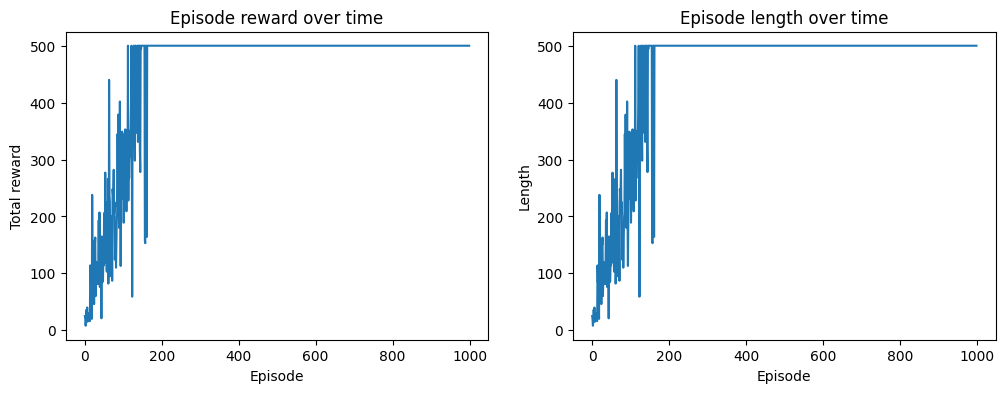

In [ ]:
env = create_env("CartPole-v1")
n_hidden = 64
lr = 0.001
net = Policy(env, continuous=False, n_hidden=n_hidden, lr=lr, optStep=.95)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode, continuous=False, bootstrapping=True)

agent.train()
agent.log()

Available device: cpu - Highest possible score: 475.0


  0%|          | 0/1000 [00:00<?, ?it/s]

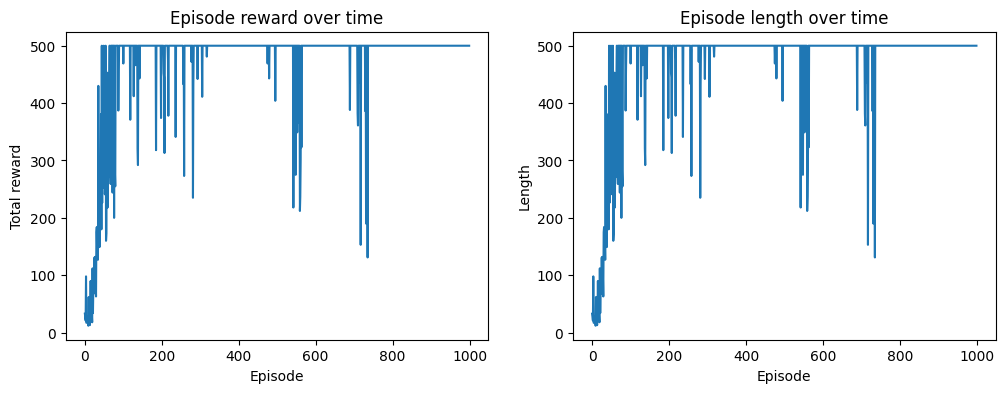

In [ ]:
env = create_env("CartPole-v1")
n_hidden = 64
lr = 0.001
net = Policy(env, continuous=False, n_hidden=n_hidden, lr=lr, optStep=.95)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode, continuous=False)

agent.train()
agent.log()

Available device: cpu - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

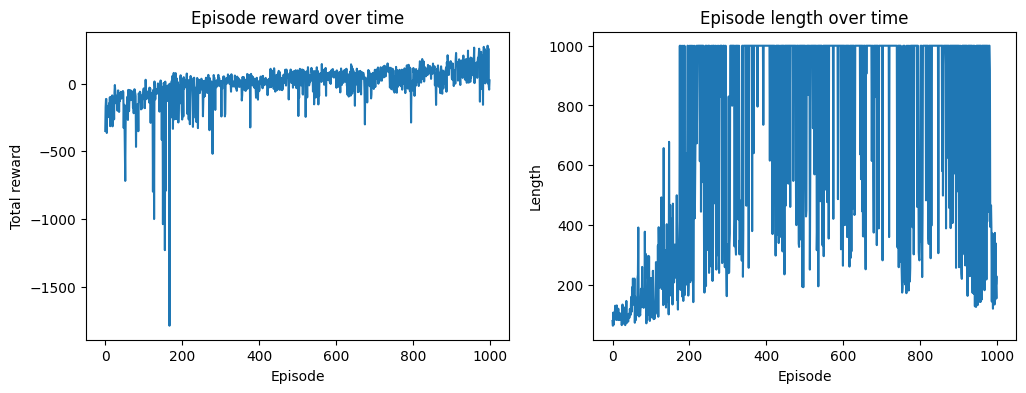

In [ ]:
env = create_env("LunarLander-v2")
n_hidden = 64
lr = 0.002
net = Policy(env, continuous=False, n_hidden=n_hidden, lr=lr, optStep=0.99)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode, continuous=False, bootstrapping=True)

agent.train()
agent.log()

In [ ]:
display_video(950)

Available device: cpu - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

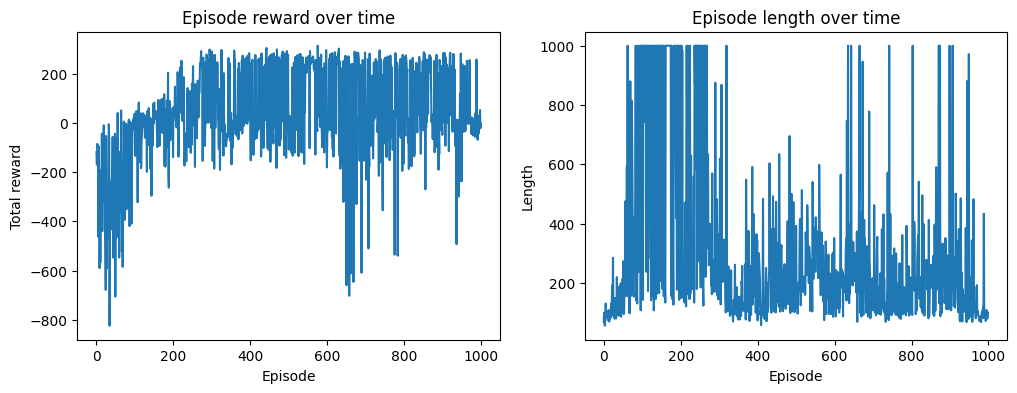

In [29]:
env = create_env("LunarLander-v2")
n_hidden = 64
lr = 0.003
net = Policy(env, continuous=False, n_hidden=n_hidden, lr=lr, optStep=.97)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode, continuous=False)

agent.train()
agent.log()

Available device: cuda - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

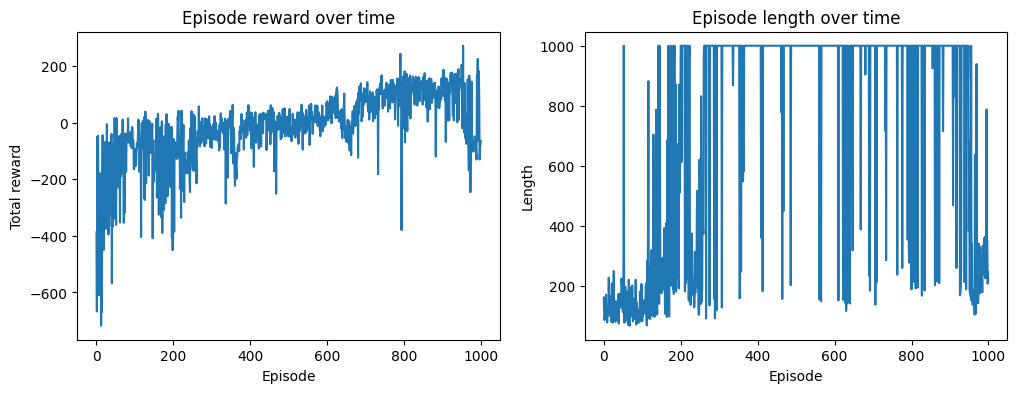

In [ ]:
env = create_env('LunarLanderContinuous-v2')
n_hidden = 64
lr = 0.001
net = Policy(env, continuous=True, n_hidden=n_hidden, lr=lr, optStep=.95)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode, continuous=True)

agent.train()
agent.log()

In [ ]:
display_video(850)

Available device: cpu - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

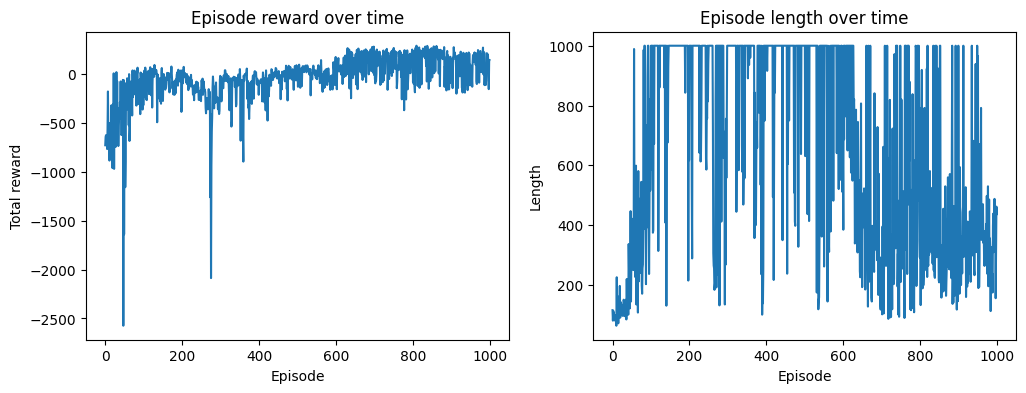

In [33]:
env = create_env('LunarLanderContinuous-v2')
n_hidden = 64
lr = 0.001
net = Policy(env, continuous=True, n_hidden=n_hidden, lr=lr, optStep=.95)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode, continuous=True, bootstrapping=True)

agent.train()
agent.log()

In [39]:
print(agent.total_reward_episode[750])
display_video(750)

266.0817505740615


## **Dynamic KL Penalty**:

$$
L(\theta) - \beta D_{\text{KL}}(\pi_\theta \| \pi_{\theta_{\text{old}}}) =\mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A^{\pi_{\theta_{\text{old}}}}(s, a) \right] - \beta \frac{1}{2} \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \left( \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} - 1 \right)^2 \right].
$$

<br>
<br>

$$
\begin{split}
L(\theta) & = e^{\left( \log \pi_\theta(a|s) - \log \pi_{\theta_{\text{old}}}(a|s) \right)} *  A^{\pi_{\theta_{\text{old}}}}(s, a) \\
\\
D_{\text{KL}}(\pi_\theta \| \pi_{\theta_{\text{old}}}) & = \Bigl( e^{\left( \log \pi_\theta(a|s) - \log \pi_{\theta_{\text{old}}}(a|s) \right)} - 1 \Bigr)^2
\end{split}
$$

<br>

---
$$
\log\left( \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} \right) = \log \pi_\theta(a|s) - \log \pi_{\theta_{\text{old}}}(a|s)
$$

In order to restore the original scale of the probabilities, we must exponentiate the logarithmic difference($e^{\ln{f(x)}} = f(x)$):

$$
\exp\left( \log \pi_\theta(a|s) - \log \pi_{\theta_{\text{old}}}(a|s) \right) = \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}
$$

---

In [46]:
# Dynamic KL Penalty (Beta Adjustment)
class PolicyPenalty():
    """
    Deep Q-Network (DQN) implementation.
    """
    def __init__(self, env, continuous=True, n_hidden=50, lr=0.05, optStep=0.9):
        """
        Initialize the DQN agent.

        Args:
            env: OpenAI Gym environment.
            n_hidden (int): Number of hidden units in the neural network.
            lr (float): Learning rate for the optimizer.
            optStep (float): Step size factor for learning rate scheduler.
        """
        self.continuous = continuous
        self.action_dim = env.action_space.shape[0] if continuous else env.action_space.n  # Number of possible actions
        self.n_state = env.observation_space.shape[0] # Dimension of state space
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Initialize the primary and target networks
        self.policy_model = PolicyNetwork(self.n_state, self.action_dim, continuous, n_hidden).to(self.device)
        self.policy_model_old = copy.deepcopy(self.policy_model)
        self.value_model = ValueNetwork(self.n_state, n_hidden).to(self.device)

        # Set up the optimizer and learning rate scheduler
        self.optimizer = torch.optim.Adam(self.policy_model.parameters(), lr)
        self.schedul = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=optStep)

        self.base_optimizer = torch.optim.Adam(self.value_model.parameters(), lr)
        self.base_schedul = torch.optim.lr_scheduler.StepLR(self.base_optimizer, step_size=50, gamma=optStep)


    def predict(self, state):
        """
        Predict Q-values for the given state using the primary network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Predicted Q-values.
        """
        if self.continuous:
            with torch.no_grad():
                mu, log_std = self.policy_model(state)  # Mean output from the network
                # log_std = torch.clamp(log_std, min=-20, max=2)
            sigma = torch.exp(log_std) + 1e-6  # Convert to standard deviation and Ensure sigma is not zero
            return Normal(mu, sigma)
        else:
            with torch.no_grad():
                logits, _ = self.policy_model(state)
                return nn.functional.softmax(logits, -1)


    def compute_advantage(self, states, returns):
        """
        Compute the advantage using the baseline (value network).

        Args:
            states (Tensor): Batch of states.
            next_states (Tensor): Batch of next_states.
            done (Tensor): Batch of done.
            returns (Tensor): Batch of discounted returns.

        Returns:
            Tensor: Advantage for each state-action pair.
        """
        with torch.no_grad():
            Value = self.value_model(states).squeeze()  # Predicted value

        return returns - Value


    def compute_policy_loss(self, states, actions, advantage, beta):

        if self.continuous:
            mu, log_std = self.policy_model(states)  # Mean output from the network
            # log_std = torch.clamp(log_std, min=-20, max=2)
            sigma = torch.exp(log_std) + 1e-6  # Convert to standard deviation and Ensure sigma is not zero
            dist = Normal(mu, sigma)
            log_probs_for_actions = dist.log_prob(actions).sum(dim=-1)  # Log-prob of the action

            with torch.no_grad():
                mu_old, log_std_old = self.policy_model_old(states)  # Mean output from the network
                sigma_old = torch.exp(log_std_old) + 1e-6
                dist_old = Normal(mu_old, sigma_old)
                log_probs_for_actions_old = dist_old.log_prob(actions).sum(dim=-1)

            kl_divergence = (
                log_std_old - log_std + (sigma**2 + (mu - mu_old)**2) / (2.0 * sigma_old**2) - 0.5
            ).sum(dim=-1).mean().item()

        else:
            logits, _ = self.policy_model(states)
            log_probs = nn.functional.log_softmax(logits, dim=-1)
            log_probs = nn.functional.log_softmax(logits, -1)
            log_probs_for_actions = log_probs[range(len(actions)), actions]

            with torch.no_grad():
                logits_old, _ = self.policy_model_old(states)
                probs_old = nn.functional.softmax(logits_old, dim=-1)
                log_probs_old = nn.functional.log_softmax(logits_old, -1)
                log_probs_for_actions_old = log_probs_old[range(len(actions)), actions]

            kl_divergence = (probs_old * (log_probs_old - log_probs)).sum(dim=-1).mean().item()


        # Compute the ratio
        ratio = torch.exp(log_probs_for_actions - log_probs_for_actions_old)
        # Compute the penalty term
        penalty = 0.5 * ((ratio - 1) ** 2).mean()
        # Surrogate loss
        surrogate = (ratio * advantage).mean()
        # Final loss
        loss = -surrogate + beta * penalty

        return loss, kl_divergence


    def update(self, states, actions, returns, target_kl=0.01,
               initial_beta=0.01, update_steps=10, value_update_steps=5):
        beta = initial_beta  # Start with an initial beta value

        for _ in range(update_steps):  # Update policy multiple times
            advantages = self.compute_advantage(states, returns)
            policy_loss, kl_divergence = self.compute_policy_loss(states, actions, advantages, beta)
            self.policy_model_old.load_state_dict(self.policy_model.state_dict())

            # Backpropagate and update the policy model
            self.optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), max_norm=0.5)  # Gradient clipping
            self.optimizer.step()

            # Update the value network separately
            for _ in range(value_update_steps):  # Separate steps for value updates
                value = self.value_model(states).squeeze()
                base_loss = nn.functional.mse_loss(value, returns)
                self.base_optimizer.zero_grad()
                base_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), max_norm=0.5)  # Gradient clipping
                self.base_optimizer.step()

            # Dynamically adjust beta based on KL divergence
            if kl_divergence > 1.5 * target_kl:
                beta = min(2 * beta, 10.0)  # Increase beta, but cap it at 10.0
            elif kl_divergence < 0.5 * target_kl:
                beta = max(0.5 * beta, 1e-5)  # Decrease beta, but keep it above 1e-5

Available device: cpu - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

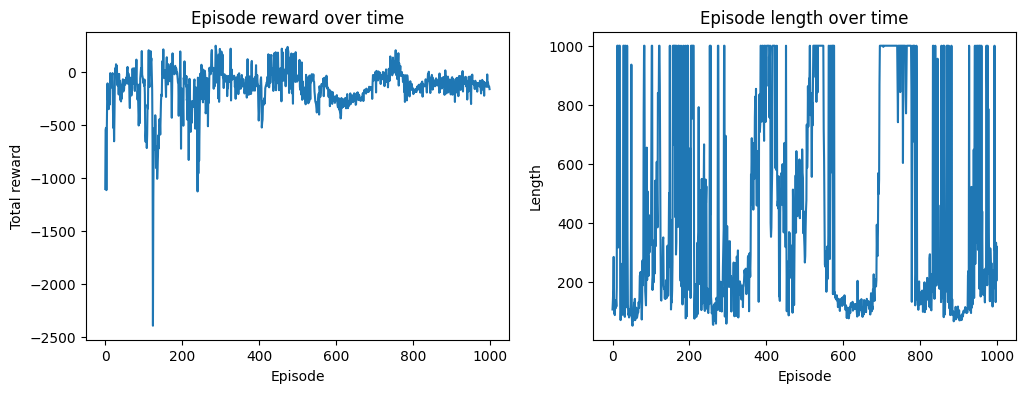

In [47]:
env = create_env('LunarLanderContinuous-v2')
n_hidden = 64
lr = 0.001
net = PolicyPenalty(env, continuous=True, n_hidden=n_hidden, lr=lr, optStep=.95)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode, continuous=True, bootstrapping=True)


agent.train()
agent.log()

Available device: cpu - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

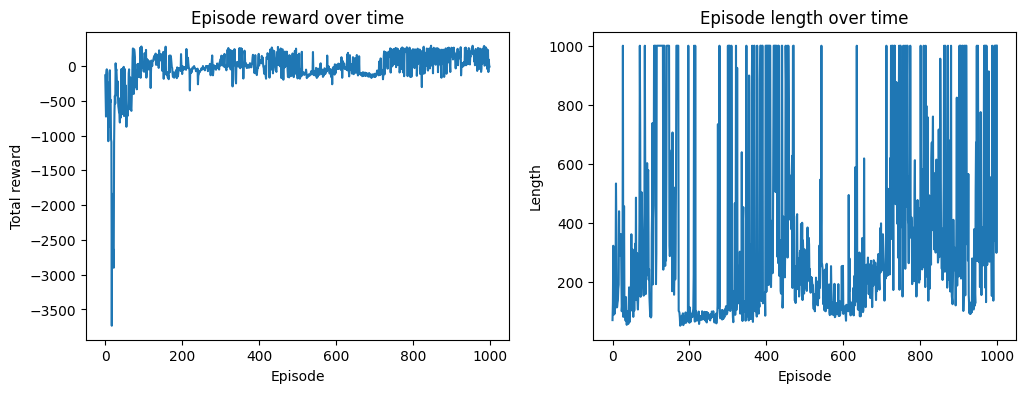

In [72]:
env = create_env('LunarLanderContinuous-v2')
n_hidden = 64
lr = 0.001
net = PolicyPenalty(env, continuous=True, n_hidden=n_hidden, lr=lr, optStep=.95)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode, continuous=True)


agent.train()
agent.log()

In [79]:
print(agent.total_reward_episode[950 - 1])
display_video(950)

140.08144788713196
